<a href="https://colab.research.google.com/github/Saugatkafley/Federated-Learning/blob/main/federated_learning_Maths_Handwritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Kaggle Dataset Maths Handwritten.
At first you have to upload the `kaggle.json` file , which can be obtained from `kaggle.com` -> `Account Settings`.
Scroll a bit and there obtain `Create New API token`. 
Then upload it to the directory.

In [ ]:
!pip install kaggle

Making a directory --> `./kaggle` 

Copying `kaggle.json` to the directory

Changing the permisssion to `600`.

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download -d sagyamthapa/handwritten-math-symbols
! kaggle datasets download -d xainano/handwrittenmathsymbols
# !unzip mnistasjpg.zip
! unzip handwrittenmathsymbols.zip
! sudo apt install unrar
! unrar x data.rar /content/data/

In [ ]:
! pip install split-folders

import splitfolders

input_folder  = '/content/data/extracted_images/'

splitfolders.ratio(
    input_folder,
    output = "dataset",
    seed =42,
    ratio = (.2,.8),
)

Copying files: 375974 files [01:12, 5167.81 files/s]


## Importing Libraries 

In [ ]:
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

!pip install imutils
from imutils import paths

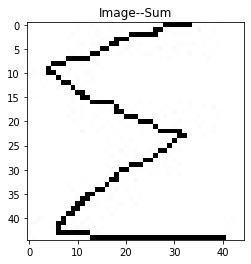

In [ ]:
# import cv2
# import matplotlib.pyplot as plt

# # img  = cv2.imread("5.png" )
# img  = cv2.imread("/content/dataset/train/sum/exp100626.jpg")
# # img_copy = img.copy()
# # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(img, cmap = 'gray')
# plt.title("Image--Sum")
# plt.show()

## Training Dataset Preprocessing.

In [ ]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels        
        image = cv2.imread(imgpath )

        # print(image.shape)
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
    return data, labels

def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  # <- IID

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 


def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    # dataset = tf.data.Dataset.from_tensor_slices(list(data), list(label))
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
  
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss


## Building CNN model
Model has `input-shape` of `[45,45,3]`

`Conv2D` layer having `filter` = `32` , `kernel_size` = `3` and Activation function  = `'relu'`

`MaxPool2D` layer having `strides` and `pool_size`  = `2`

And the after 2 `Conv2D`layers the layers are `Flatten`.
The layers are then fully connected by `Dense` layers . 

The output is `Dense` layer of `82` units having activation `softmax`.

In [ ]:
def create_keras_model(shape , classes):
  model = tf.keras.Sequential()
  
  model.add(tf.keras.layers.Conv2D(filters =32 , kernel_size =3  , activation='relu' , input_shape = [shape[0], shape[1] , shape[2] ]))
  # model.add(Lambda(lambda x: expand_dims(x, axis=-1)))
  # model.add(tf.keras.layers.Conv2D(filters =32 , kernel_size =3  , activation='relu' , input_shape  =(shape,)))
  model.add(tf.keras.layers.MaxPool2D( strides = 2,pool_size=2))

  model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3 , activation = 'relu' ))
  model.add(tf.keras.layers.MaxPool2D(strides = 2, pool_size  =2))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units  = 128 , activation = 'relu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(units  = 128 , activation = 'relu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(units  =classes  ,activation  ='softmax'))
  return model  

## Getting Image from the directories and giving them respective labels. 

`Labels` are then binary encoding by `LabelBinarizer()`

In [ ]:
#declear path to your Image data folder

img_path = './dataset/train/'
image_paths = sorted(list(paths.list_images(img_path)))

#apply our function
image_list, label_list = load(image_paths)

print(len(image_list))
#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)
print(len(label_list))

75161
75161


Splitting dataset into `X_train, X_test, y_train, y_test`

In [ ]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

### IID

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(67644, 7517, 67644, 7517)

## Creating Clients and batching them with datasets.

In [ ]:
#create clients
num_clients = 10
clients = create_clients(X_train, y_train, num_clients=num_clients, initial='client') #10 clients

In [ ]:
# process and batch the training data for each client
clients_batched  = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

## Global Training Parameters

In [ ]:
comms_round = 1
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer  = 'adam'    

In [ ]:
#initialize global model
build_shape = [45,45,3] # Train image Dimensions
classes = 82
global_model = create_keras_model(build_shape , classes)
global_acc_list = []
global_loss_list = []

In [ ]:
#commence global training loop
for comm_round in range(comms_round):
          
  # get the global model's weights - will serve as the initial weights for all local models
  global_weights = global_model.get_weights()
  
  #initial list to collect local model weights after scalling
  scaled_local_weight_list = list()

  #randomize client data - using keys
  all_client_names = list(clients_batched.keys())
          
  client_names = random.sample(all_client_names, k=10)
  # print(client_names, len(client_names))
  random.shuffle(client_names)

  #loop through each client and create new local model
  for client in client_names:
    local_model = create_keras_model(build_shape, classes)
    local_model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=metrics)
    
    #set local model weight to the weight of the global model
    local_model.set_weights(global_weights)
    #fit local model with client's data
    local_model.fit(clients_batched[client], epochs=1)
    
    #scale the model weights and add to list
    scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
    
    scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
    scaled_local_weight_list.append(scaled_weights)
    
    #clear session to free memory after each communication round
    K.clear_session()
    
  #to get the average over all the local model, we simply take the sum of the scaled weights
  average_weights = sum_scaled_weights(scaled_local_weight_list)
  
  #update global model 
  global_model.set_weights(average_weights)

  #test global model and print out metrics after each communications round
  for(X_test, Y_test) in test_batched:
      global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
      global_acc_list.append(global_acc)
      global_loss_list.append(global_loss)

ValueError: ignored

## Making a single prediction with Global Model

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('5.png' , target_size = (45,45))
#change to PIL format
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image , axis = 0) #extra dimension to batch
result = global_model.predict(test_image)
result = lb.inverse_transform(result)
result1 = "".join(str(e) for e in result)
print(result1)

4


## Saving and Loading Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
global_model.save("/content/drive/MyDrive/global_model/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/global_model/assets


In [ ]:
import tensorflow as tf
global_model = tf.keras.models.load_model("/content/drive/MyDrive/global_model/")

## Using OPENCV to classify multiple digits prediction using bounding box.


In [ ]:
! pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=fee381913925f6d1964e2854bc31f2d2f69df3e92e03d45266f0b2a58194dccd
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/wget-3.2.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:
import wget
file_name = wget.download ("https://i.imgur.com/hRmXkdQ.png")
# ! wget https://i.imgur.com/PwWiTk8.png
# file_url  = "https://i.imgur.com/PwWiTk8.png"
# file_name = file_url.split("/")[-1]


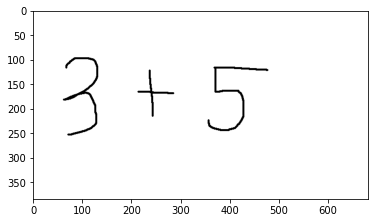

In [ ]:
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt

# img  = cv2.imread("5.png" )
img  = cv2.imread(file_name)
img_copy = img.copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap = 'gray')
plt.show()

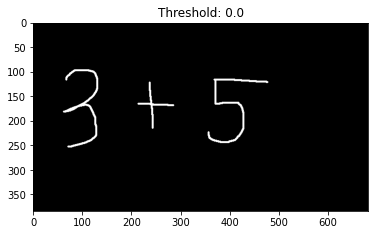

In [ ]:
# img = image.img_to_array(img, dtype='uint8')
(thresh, img_bin) = cv2.threshold(img_gray, 20, 255 , cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(img_bin,cmap='gray')
plt.title('Threshold: {}'.format(thresh))
plt.show()

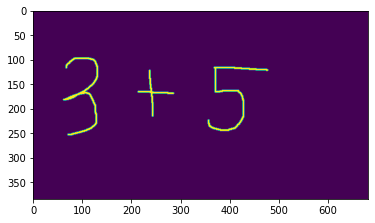

In [ ]:
cv2.floodFill(img_bin, None, (0, 0), 0)
plt.imshow(img_bin,)

In [ ]:
# Get each bounding box
# Find the big contours/blobs on the filtered image:

# Bug use img_gray not binary image 
contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

['3']


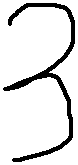

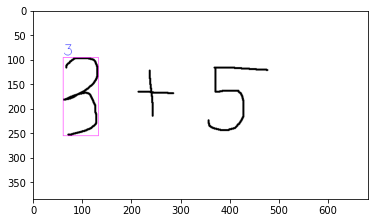

['3', '+']


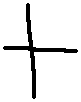

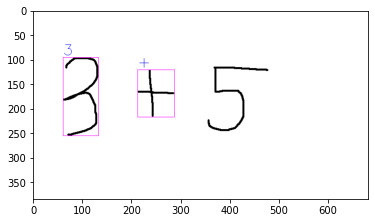

['3', '+', '5']


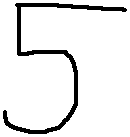

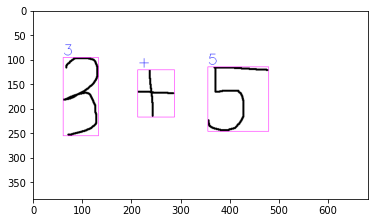

8


In [ ]:
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
import numpy as np
predictions  = []
# Look for the outer bounding boxes (no children):
current_crop = [] # hold the cropped images
for _, c in enumerate(sorted_ctrs):

  # Get the bounding rectangle of the current contour:
  boundRect = cv2.boundingRect(c)

  # Get the bounding rectangle data:
  rectX = boundRect[0]
  rectY = boundRect[1]
  rectWidth = boundRect[2]
  rectHeight = boundRect[3]
  
  # Estimate the bounding rect area:
  rectArea = rectWidth * rectHeight
  # print(rectArea)
  # Set a min area threshold
  minArea =40

  # Filter blobs by area:
  if rectArea > minArea:

    # Draw bounding box:
    color = (255, 0, 255)
    cv2.rectangle(img_copy, (int(rectX), int(rectY)),
                  (int(rectX + rectWidth), int(rectY + rectHeight)), color, 1)

    # Crop bounding box:
    currentCrop = img[rectY-3:rectY+rectHeight+3,rectX-3:rectX+rectWidth+3]
    current_crop.append(currentCrop)
    # Resize image to (45,45)
    test_image = cv2.resize(currentCrop, (45,45), interpolation = cv2.INTER_AREA)
    #change to PIL format
    # test_image  = cropped_image
    test_image = image.img_to_array(test_image) 
    test_image = np.expand_dims(test_image , axis = 0) #extra dimension to batch
    result = global_model.predict(test_image)
    result = lb.inverse_transform(result)
    result1 = "".join(str(e) for e in result)
    predictions.append(result1)
    print(predictions)
    cv2.putText(img_copy ,result1, (int(rectX), int(rectY)-5 ),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),1)
    cv2_imshow(currentCrop)
    # img_copy = cv2.resize(img_copy, (100,100), interpolation = cv2.INTER_AREA)
    # cv2_imshow(img_copy)
    plt.imshow(img_copy, cmap = 'gray')
    plt.show()

    cv2.waitKey(0)
pred = "".join(str(e) for e in predictions)
print(eval(pred))

## Model Evaluation Metrics


In [ ]:
y_pred  = global_model.predict(X_test)
# y_pred = np.argmax(y_pred,axis=1)
print(y_pred)
y_pred = lb.inverse_transform(y_pred)
print(y_pred)

[[1.62797875e-09 1.34542990e-08 6.08463836e-07 ... 1.50830513e-08
  8.72028036e-13 9.47508131e-12]
 [2.33303144e-04 9.08543766e-01 4.95233544e-05 ... 6.23217147e-06
  4.78536967e-05 2.55212854e-07]
 [3.73847166e-13 6.90111923e-09 4.96726306e-11 ... 1.04268620e-04
  7.82541133e-12 5.85806794e-12]
 ...
 [2.08677022e-08 4.83069243e-07 1.06348692e-04 ... 5.15243388e-04
  1.07109925e-10 5.27016208e-11]
 [9.50727148e-23 1.29899086e-12 2.13343943e-11 ... 2.65481456e-11
  9.87003054e-21 2.04515091e-20]
 [2.13788386e-18 6.09139974e-08 2.90005487e-13 ... 2.69836491e-08
  4.84405708e-14 7.58452952e-15]]
['-' '(' 'X' ... '2' 'sin' 'b']


In [ ]:
y_test1 = y_test.copy()
print(y_test1)
# y_test1 = lb.inverse_transform(y_test1)
y_test1 = lb.inverse_transform(y_test1)
print(y_test1)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['-' '(' 'times' ... '2' 'sin' 'b']


In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test1,y_pred)


(81, 81)


In [ ]:
import warnings
warnings.filterwarnings('always')
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision , recall , fscore , support = precision_recall_fscore_support(y_test1,y_pred , average='weighted')
print("Precision: {:.3f}\n Recall: {:.3f}\n fscore: {:.3f}\n Support: {}\n".format(precision , recall , fscore , support))

Precision: 0.901
 Recall: 0.909
 fscore: 0.902
 Support: None



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
labels = ['!','(',')','+',',','-','0','1','2','3','4','5','6','7','8','9','=','A','C',
 'Delta','G','H','M','N','R','S','T','X','[',']','alpha','ascii_124','b',
 'beta','cos','d','div','e','exists','f','forall','forward_slash','gamma','geq','gt',
 'i','in','infty','int','j','k','l','lambda','ldots','leq','lim','log','lt','mu',
 'neq','o','p','phi','pi','pm',
#  'prime',
 'q','rightarrow','sigma','sin','sqrt','sum','tan','theta','times','u','v','w','y','z','{','}']

In [ ]:
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt

# df_cm = pd.DataFrame(cm, index = [i for i in labels],
#                   columns = [i for i in labels])
# plt.figure(figsize = (30,30))
# sns.heatmap(df_cm, annot=True , cmap = "Blues")

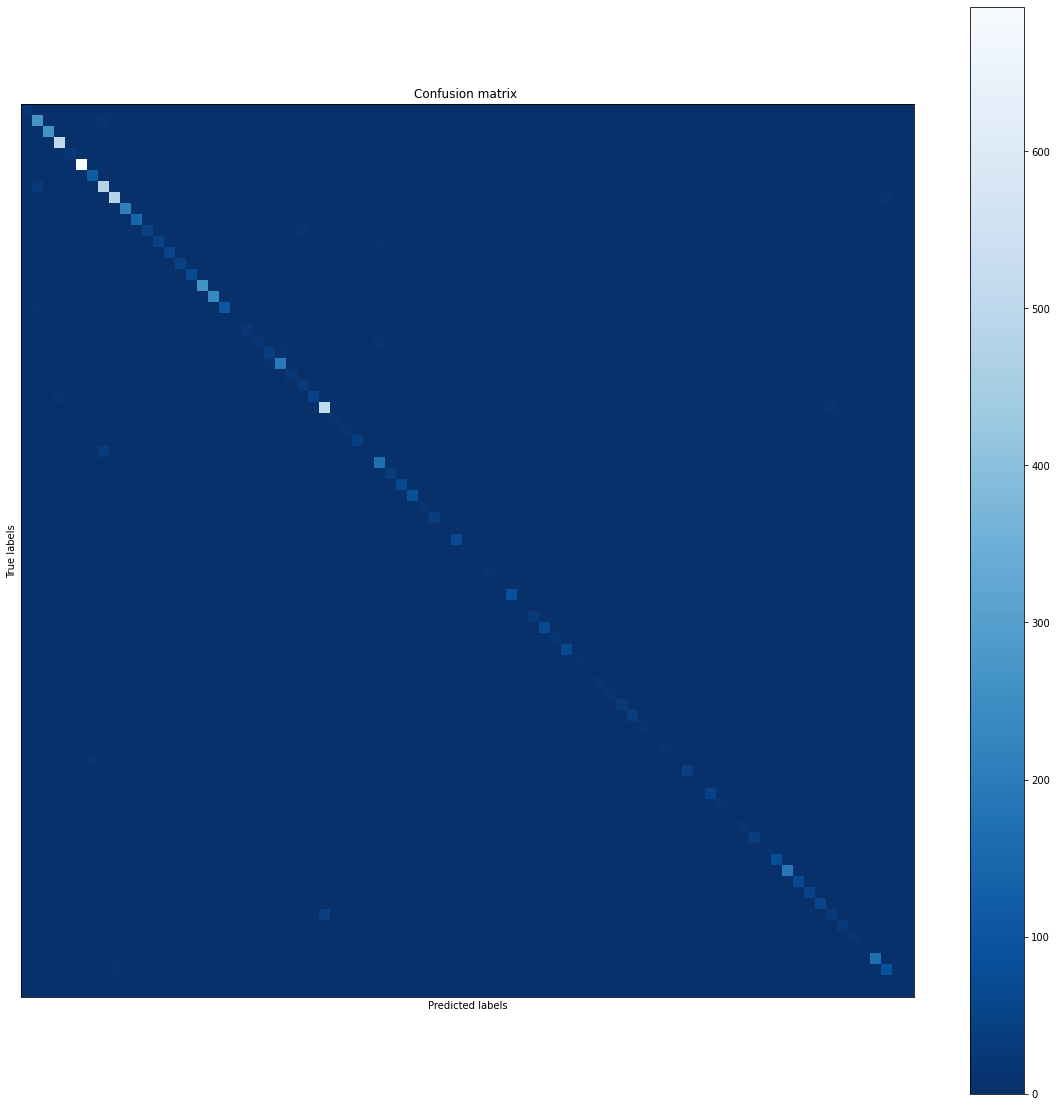

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
plt.imshow(cm, cmap=plt.cm.Blues_r)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# x_data = []
# y_data = []

# fig, ax = plt.subplots()
# ax.set_xlim(0,20)
# ax.set_ylim(0, 0.95)
# line, = ax.plot(0, 0)
# arr = list(range(0, len(global_acc_list)))
# def animation_frame(i):
#   x_data = arr[:i]
#   y_data = global_acc_list[:i]

#   line.set_xdata(x_data)
#   line.set_ydata(y_data)
	
#   return line, 
# animation = FuncAnimation(fig, func=animation_frame, frames = 100, interval=40 , blit= True)
# HTML(animation.to_html5_video())

IID | total comm rounds 20


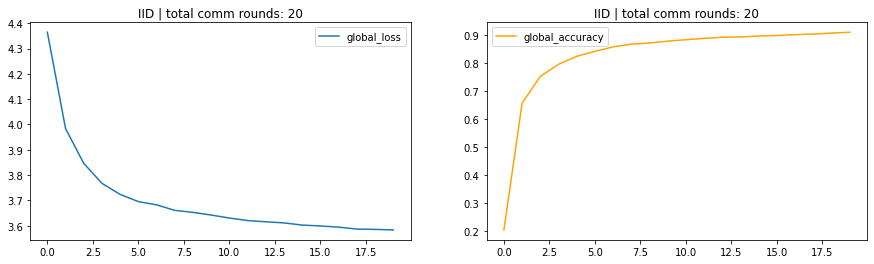

In [ ]:
# IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title("IID | total comm rounds: {}".format(len(global_acc_list)))
plt.plot(list(range(0,len(global_loss_list))), global_loss_list ,  label = "global_loss") 
plt.legend()
plt.subplot(122)
plt.title("IID | total comm rounds: {}".format(len(global_acc_list)))
plt.plot(list(range(0,len(global_acc_list))), global_acc_list , label = 'global_accuracy' , color = 'orange')
plt.legend()
print('IID | total comm rounds', len(global_acc_list))

In [ ]:
iid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
iid_df.to_csv('IID.csv',index=False)

### Non-IID

In [ ]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    # dataset = tf.data.Dataset.from_tensor_slices(list(data), list(label))
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
  ''' return: a dictionary with keys clients' names and value as 
              data shards - tuple of images and label lists.
      args: 
          image_list: a list of numpy arrays of training images
          label_list:a list of binarized labels for each image
          num_client: number of fedrated members (clients)
          initials: the clients'name prefix, e.g, clients_1 
          
  '''

  #create a list of client names
  client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

  #randomize the data
  # data = list(zip(image_list, label_list))
  # random.shuffle(data)  # <- IID
  
  # sort data for non-iid
  max_y = np.argmax(label_list, axis=1)
  sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
  data = [(x,y) for _,y,x in sorted_zip]

  #shard data and place at each client
  size = len(data)//num_clients
  shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

  #number of clients must equal number of shards
  # assert(len(shards) == len(client_names))

  return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(67644, 7517, 67644, 7517)

In [ ]:
#create clients
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [ ]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
comms_round = 20
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer  = 'adam'
  

In [ ]:
#initialize global model

build_shape = [45,45,3] # Shape of Image
classes = 82
global_model = create_keras_model(build_shape , classes)
global_acc_list = []
global_loss_list = []

In [ ]:
#commence global training loop
for comm_round in range(comms_round):
            
  # get the global model's weights - will serve as the initial weights for all local models
  global_weights = global_model.get_weights()

  #initial list to collect local model weights after scalling
  scaled_local_weight_list = list()

  #randomize client data - using keys
  # all_client_names = list(clients_batched.keys())
          
  client_names = list(clients_batched.keys())
  print(client_names)
  # random.shuffle(client_names)

  #loop through each client and create new local model
  for client in client_names:
    local_model = create_keras_model(build_shape, classes)
    local_model.compile(loss=loss, 
                optimizer=optimizer, 
                metrics=metrics)

    #set local model weight to the weight of the global model
    local_model.set_weights(global_weights)

    #fit local model with client's data
    local_model.fit(clients_batched[client], epochs=1, workers = 8 )
      
    #scale the model weights and add to list
    scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
    scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
    scaled_local_weight_list.append(scaled_weights)
    # print(scaled_local_weight_list)
      
    #clear session to free memory after each communication round
    K.clear_session()
      
  #to get the average over all the local model, we simply take the sum of the scaled weights
  average_weights = sum_scaled_weights(scaled_local_weight_list)

  #update global model 
  global_model.set_weights(average_weights)

  #test global model and print out metrics after each communications round
  for(X_test, Y_test) in test_batched:
      global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
      global_acc_list.append(global_acc)
      global_loss_list.append(global_loss)

['client_1', 'client_2', 'client_3', 'client_4', 'client_5', 'client_6', 'client_7', 'client_8', 'client_9', 'client_10']
212/212 [==============================] - 3s 9ms/step - loss: 1.1777 - accuracy: 0.6600
comm_round: 0 | global_acc: 5.654% | global_loss: 4.40455436706543
['client_1', 'client_2', 'client_3', 'client_4', 'client_5', 'client_6', 'client_7', 'client_8', 'client_9', 'client_10']
212/212 [==============================] - 3s 9ms/step - loss: 0.7764 - accuracy: 0.7812
comm_round: 1 | global_acc: 24.385% | global_loss: 4.3903117179870605
['client_1', 'client_2', 'client_3', 'client_4', 'client_5', 'client_6', 'client_7', 'client_8', 'client_9', 'client_10']
212/212 [==============================] - 3s 9ms/step - loss: 0.6526 - accuracy: 0.8124
comm_round: 2 | global_acc: 28.150% | global_loss: 4.3578901290893555
['client_1', 'client_2', 'client_3', 'client_4', 'client_5', 'client_6', 'client_7', 'client_8', 'client_9', 'client_10']
212/212 [=============================

NON-IID | total comm rounds 20


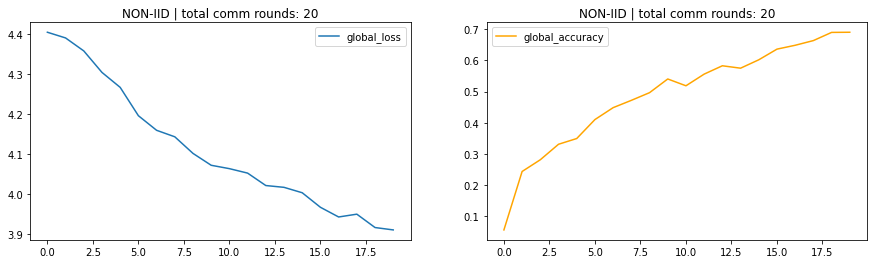

In [ ]:
# NON-IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title("NON-IID | total comm rounds: {}".format(len(global_acc_list)))
plt.plot(list(range(0,len(global_loss_list))), global_loss_list ,  label = "global_loss") 
plt.legend()
plt.subplot(122)
plt.title("NON-IID | total comm rounds: {}".format(len(global_acc_list)))
plt.plot(list(range(0,len(global_acc_list))), global_acc_list , label = 'global_accuracy' , color = 'orange')
plt.legend()
print('NON-IID | total comm rounds', len(global_acc_list))

## Traing By Solely on CNN for 20 Epochs

In [ ]:
cnn_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)

In [ ]:
build_shape = [45,45,3] # Train image Dimensions
classes = 82
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer  = 'adam'   

In [ ]:
cnn_model = create_keras_model( build_shape , classes)
cnn_model.compile(
  loss=loss, 
  optimizer=optimizer, 
  metrics=metrics
)

In [ ]:
cnn_model.fit(cnn_dataset , epochs = 20)

Epoch 1/20
2114/2114 [==============================] - 202s 94ms/step - loss: 1.3969 - accuracy: 0.6450
Epoch 2/20
2114/2114 [==============================] - 143s 66ms/step - loss: 0.7519 - accuracy: 0.7924
Epoch 3/20
2114/2114 [==============================] - 143s 66ms/step - loss: 0.6084 - accuracy: 0.8262
Epoch 4/20
2114/2114 [==============================] - 144s 67ms/step - loss: 0.5286 - accuracy: 0.8472
Epoch 5/20
2114/2114 [==============================] - 144s 67ms/step - loss: 0.4783 - accuracy: 0.8609
Epoch 6/20
2114/2114 [==============================] - 144s 67ms/step - loss: 0.4344 - accuracy: 0.8708
Epoch 7/20
2114/2114 [==============================] - 145s 67ms/step - loss: 0.3990 - accuracy: 0.8808
Epoch 8/20
2114/2114 [==============================] - 145s 67ms/step - loss: 0.3709 - accuracy: 0.8884
Epoch 9/20
2114/2114 [==============================] - 144s 67ms/step - loss: 0.3490 - accuracy: 0.8938
Epoch 10/20
2114/2114 [==============================] 

In [ ]:
# for(X_test, Y_test) in test_batched:
#         acc, loss = test_model(X_test, Y_test, cnn_model, 1)

In [ ]:
acc_list = cnn_model.history.history['accuracy']
loss_list = cnn_model.history.history['loss']


CNN Training for 20 epochs


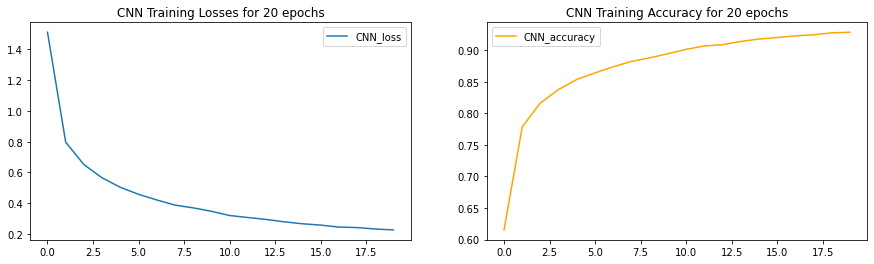

In [ ]:
# Single CNN 
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title("CNN Training Losses for 20 epochs")
plt.plot(list(range(0,len(loss_list))), loss_list ,  label = "CNN_loss") 
plt.legend()
plt.subplot(122)
plt.title("CNN Training Accuracy for 20 epochs")
plt.plot(list(range(0,len(acc_list))), acc_list , label = 'CNN_accuracy' , color = 'orange')
plt.legend()
print('CNN Training for 20 epochs')

In [ ]:
y_pred  = cnn_model.predict(X_test)
# y_pred = np.argmax(y_pred,axis=1)
print(y_pred)
y_pred = lb.inverse_transform(y_pred)
print(y_pred)